# Challenge 4
Series de tiempo

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import math
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

In [215]:
df = pd.read_csv('series.csv')

In [216]:
df.dtypes

CATEGORY      object
DATE          object
UNITS_SOLD     int64
dtype: object

In [217]:
df['CATEGORY'].value_counts()

CATEG-3    920
CATEG-1    887
CATEG-2    879
Name: CATEGORY, dtype: int64

In [218]:
df['DATE'] = pd.to_datetime(df['DATE'])

In [219]:
df = df.sort_values('DATE')
df = df.set_index('DATE')
# df = df.asfreq('d')

In [220]:
df['CATEGORY'].unique()

array(['CATEG-3', 'CATEG-1', 'CATEG-2'], dtype=object)

In [221]:
df_category3 = df.query('CATEGORY=="CATEG-3"').asfreq('d')
df_category2 = df.query('CATEGORY=="CATEG-2"').asfreq('d')
df_category1 = df.query('CATEGORY=="CATEG-1"').asfreq('d')

In [222]:
df_category3 = df_category3.fillna({'CATEGORY':"CATEG-3",'UNITS_SOLD':0})
df_category2 = df_category2.fillna({'CATEGORY':"CATEG-2",'UNITS_SOLD':0})
df_category1 = df_category1.fillna({'CATEGORY':"CATEG-1",'UNITS_SOLD':0})

<AxesSubplot:xlabel='DATE'>

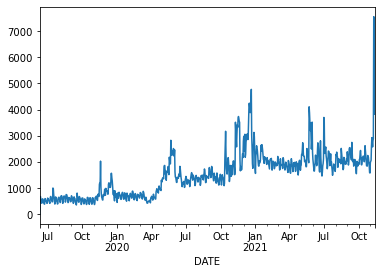

In [223]:
df_category3['2019-06-10'::]['UNITS_SOLD'].plot()

<AxesSubplot:xlabel='DATE'>

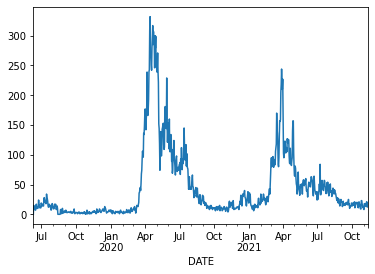

In [37]:
df_category2['2019-06-10'::]['UNITS_SOLD'].plot()

<AxesSubplot:xlabel='DATE'>

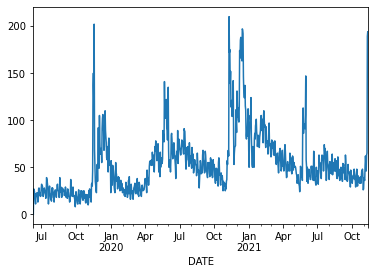

In [38]:
df_category1['2019-06-10'::]['UNITS_SOLD'].plot()

In [39]:
df_category1['2019-06-10'::]

,CATEGORY,UNITS_SOLD
DATE,,
2019-06-10,CATEG-1,0.0
2019-06-11,CATEG-1,27.0
2019-06-12,CATEG-1,26.0
2019-06-13,CATEG-1,24.0
2019-06-14,CATEG-1,18.0
...,...,...
2021-11-08,CATEG-1,63.0
2021-11-09,CATEG-1,65.0
2021-11-10,CATEG-1,189.0


In [224]:
df_category3 = df_category3['2019-06-10'::]
df_category2 = df_category2['2019-06-10'::]
df_category1 = df_category1['2019-06-10'::]

## Checking the peridogram

In [225]:
train_start = '2019-06-11'	
validation_start = '2020-11-23'
test_start = '2021-05-20'

In [226]:
df_category1_train = df_category1[train_start:'2020-11-22']
df_category1_validation = df_category1[validation_start:'2021-05-19']

In [62]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

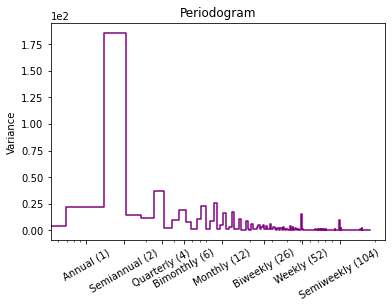

In [341]:
plot_periodogram(df_category1_train['UNITS_SOLD'])

13 harmonics in the fourier series would be satisfatory to capture the most of the seasonality relationship

## Dividing the training sets

In [228]:
train_start = '2019-06-11'	
validation_start = '2020-11-23'
test_start = '2021-05-20'

In [229]:
df = pd.concat([df_category3, df_category2, df_category1])

In [230]:
df.shape

(2661, 2)

In [231]:
df = df.dropna()
df = df.sort_index()

In [323]:
def minus_one_day(t):
    '''
        Gives date t minus one day
    '''
    t_minus_one = datetime.strptime(t,'%Y-%m-%d') + timedelta(days=-1)
    return t_minus_one.strftime('%Y-%m-%d')

def get_train_val_set(df, train_start, validation_start, test_start,  fourier_pairs=13, trend_order=1):
    '''
        Get train set with seasonal features, deterministic process and validation set
    '''
    
    df_train = df[train_start:minus_one_day(validation_start)]
    df_validation = df[validation_start:minus_one_day(test_start)]
    # Generate features for training
    df_train_res = pd.DataFrame()
    dps = []
    for cat in np.sort(df['CATEGORY'].unique()):
        df_category_train = df_train[df_train['CATEGORY'] == cat].copy().asfreq('D')
        
        # X.head()
        fourier = CalendarFourier(freq="A", order=fourier_pairs)  # 13 sin/cos pairs for Annual

        dp = DeterministicProcess(
            index=df_category_train.index,
            constant=True,               # dummy feature for bias (y-intercept)
            seasonal=False,
            order=trend_order,           # trend (order 1 means linear)
            additional_terms=[fourier],  # annual seasonality (fourier)
            drop=True,                   # drop terms to avoid collinearity
        )
        df_category_features = dp.in_sample()
        df_category_train = pd.concat([df_category_train, df_category_features], axis=1)  
        # df_category_train['CATEGORY'] = cat
        
        df_train_res = pd.concat([df_train_res,df_category_train])
        dps.append(dp)
    return df_train_res,dps, df_validation
        

In [239]:
df_train, dps, df_val = get_train_val_set(df, train_start, validation_start, test_start)

<AxesSubplot:xlabel='DATE'>

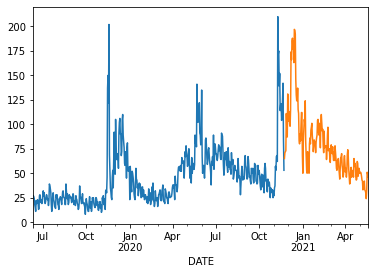

In [125]:
df_train.query('CATEGORY == "CATEG-1"')['UNITS_SOLD'].plot()
df_val.query('CATEGORY == "CATEG-1"')['UNITS_SOLD'].plot()

In [324]:
def train_linear_regression(df_train):
    '''
       Train linear regression for each category
    '''
    models = []
    for cat in np.sort(df['CATEGORY'].unique()):
        df_train_cat = df_train[df_train['CATEGORY'] == cat]
        y = df_train_cat["UNITS_SOLD"]  # the target
        X = df_train_cat.drop(columns=['CATEGORY', 'UNITS_SOLD'])
        model = LinearRegression(fit_intercept=False)
        model.fit(X, y)
        models.append(model)
        # y_pred = pd.Series(model.predict(X), index=X.index)
    return models

In [241]:
models = train_linear_regression(df_train)

In [160]:
df_val

,CATEGORY,UNITS_SOLD
DATE,,
2020-11-23,CATEG-1,65
2020-11-23,CATEG-2,10
2020-11-23,CATEG-3,1830
2020-11-24,CATEG-2,10
2020-11-24,CATEG-1,71
...,...,...
2021-05-18,CATEG-1,49
2021-05-18,CATEG-2,46
2021-05-19,CATEG-1,46


In [266]:
y_pred = []
for model,dp in zip(models,dps):
    X = dp.out_of_sample(steps=178)
    y_pred.append(pd.Series(model.predict(X), index=X.index))
y = []
for cat in np.sort(df['CATEGORY'].unique()):
    y.append(df_val[df_val['CATEGORY'] == cat]['UNITS_SOLD'])

<AxesSubplot:xlabel='DATE'>

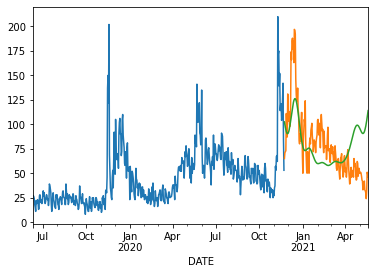

In [267]:
df_train[df_train['CATEGORY'] == 'CATEG-1']['UNITS_SOLD'].plot()
y[0].plot()
y_pred[0].plot()

In [268]:
def flatten(t):
    return [item for sublist in t for item in sublist]
y = flatten(y)
y_pred = flatten(y_pred)

In [274]:
print('Validation RMSE: ',math.sqrt(mean_squared_error(y, y_pred)))

Validation RMSE:  374.9813556015484


In [276]:
df_train['UNITS_SOLD'].std()

592.2705709815182

Considering the standard deviation of UNITS_SOLD are 592 in the training set and that the RMSE have the same magnitude of the target value, the RMSE = 374 in the forcast of 178 days of the validation set makes it a reasonable good model to predict it.

Below, I going to increase the order of trend features and see if it makes a better predictor

In [326]:
df_train, dps, df_val = get_train_val_set(df, train_start, validation_start, test_start, fourier_pairs=13, trend_order=3)

In [327]:
models = train_linear_regression(df_train)

In [328]:
y_pred = []
for model,dp in zip(models,dps):
    X = dp.out_of_sample(steps=178)
    y_pred.append(pd.Series(model.predict(X), index=X.index))
y = []
for cat in np.sort(df['CATEGORY'].unique()):
    y.append(df_val[df_val['CATEGORY'] == cat]['UNITS_SOLD'])

<AxesSubplot:xlabel='DATE'>

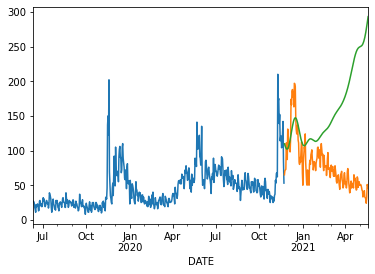

In [329]:
df_train[df_train['CATEGORY'] == 'CATEG-1']['UNITS_SOLD'].plot()
y[0].plot()
y_pred[0].plot()

In [330]:
def flatten(t):
    return [item for sublist in t for item in sublist]
y = flatten(y)
y_pred = flatten(y_pred)

In [331]:
print('Validation RMSE: ', math.sqrt(mean_squared_error(y, y_pred)))

Validation RMSE:  2451.0277936773277


It increased the error a lot, making it a worse predictor

Below, the RMSE for the test set with the best model. The train set here is composed with both previously train and validation set

In [332]:
df_train, dps, df_val = get_train_val_set(df, train_start, test_start,'2021-11-12', fourier_pairs=13, trend_order=1)

In [333]:
models = train_linear_regression(df_train)

In [334]:
y_pred = []
for model,dp in zip(models,dps):
    X = dp.out_of_sample(steps=176)
    y_pred.append(pd.Series(model.predict(X), index=X.index))
y = []
for cat in np.sort(df['CATEGORY'].unique()):
    y.append(df_val[df_val['CATEGORY'] == cat]['UNITS_SOLD'])

<AxesSubplot:xlabel='DATE'>

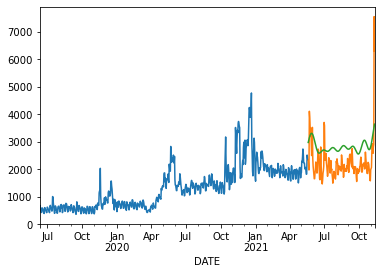

In [335]:
df_train[df_train['CATEGORY'] == 'CATEG-3']['UNITS_SOLD'].plot()
y[2].plot()
y_pred[2].plot()

In [336]:
def flatten(t):
    return [item for sublist in t for item in sublist]
y = flatten(y)
y_pred = flatten(y_pred)

In [337]:
print('Validation RMSE: ', math.sqrt(mean_squared_error(y, y_pred)))

Validation RMSE:  483.07222800764237
